# Develop applying NEWT on ISIMIP data arrays

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, statsmodels

import numpy as np
import pandas as pd
import os, glob, re, sys
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

In [2]:
sys.path.append('../atmos/')
from atmos import thermo

In [3]:
# import my scripts/settings/utils etc

# open ISIMIP data and make new calc_wbgt_newt fxn -> put it in functions.py

# rename functions.py etc 

# later: re-unify fxns and fxns_ana??? > clean this up a bit 
# write at start if sys_argv == None, then sys =0 

In [4]:
# from settings import *
# from utils import * 

# # check compatibility later ! 

In [5]:

from settings_ana import *
from utils_ana import * 

In [6]:
from dask.distributed import Client 
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44245,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:36909,Total threads: 1
Dashboard: http://127.0.0.1:46571/status,Memory: 20.00 GiB
Nanny: tcp://127.0.0.1:34073,


## Test on ISIMIP data

In [7]:
GCM = GCMs[0]

In [8]:
dir1, dir2 = get_dirpaths(GCM, 'historical', 'ssp370')

In [9]:
dir1, dir2

('/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/historical/CanESM5',
 '/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/ssp370/CanESM5')

In [10]:
variables = VARs=['tasmax','huss', 'ps']

In [11]:
filepaths = [get_filepaths(VAR,dir1,dir2) for VAR in variables]

In [12]:
for i in range(len(filepaths[0])):
    print(i)
    startyear,endyear = xr.open_dataarray(filepaths[0][i]).time.dt.year[[0,-1]]
    print(startyear.values,endyear.values)

0
1850 1850
1
1851 1860
2
1861 1870
3
1871 1880
4
1881 1890
5
1891 1900
6
1901 1910
7
1911 1920
8
1921 1930
9
1931 1940
10
1941 1950
11
1951 1960
12
1961 1970
13
1971 1980
14
1981 1990
15
1991 2000
16
2001 2010
17
2011 2014
18
2015 2020
19
2021 2030
20
2031 2040
21
2041 2050
22
2051 2060
23
2061 2070
24
2071 2080
25
2081 2090
26
2091 2100


In [13]:
filesavename = get_filesavename(GCM, 
                                'historical',
                                    None, # can put 'None' later to do them just one by one 
                                    ext='WBGT', 
                               # filepath = filepaths[0][0],
                                 startyear=startyear.values, 
                                endyear=endyear.values, 
                                keep_scenario=True,
                               variable='tasmax') 

In [14]:
filesavename

'canesm5_r1i1p1f1_w5e5_historical_WBGT_2091_2100.nc'

In [15]:
filepath = filepaths[0][0]

In [16]:
os.path.basename(filepath)

'canesm5_r1i1p1f1_w5e5_historical_tasmax_global_daily_1850_1850.nc'

In [17]:
make_outdir(GCM, 
                              makedirs=False, 
                              scratchdir=True,
                              outdirname='output_jan25',
                             experiment='ssp370')

'/scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_jan25/WBGT28/ISIMIP3b/ssp370/CanESM5'

In [18]:
i

26

In [19]:
tasmax,huss,ps= [xr.open_dataarray(files[i]) for files in filepaths]

In [20]:
tasmax

<xarray.DataArray 'tasmax' (time: 3652, lat: 360, lon: 720)>
[946598400 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) datetime64[ns] 2091-01-01 2091-01-02 ... 2100-12-31
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    units:          K

In [21]:
huss

<xarray.DataArray 'huss' (time: 3652, lat: 360, lon: 720)>
[946598400 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) datetime64[ns] 2091-01-01 2091-01-02 ... 2100-12-31
Attributes:
    standard_name:  specific_humidity
    long_name:      Near-Surface Specific Humidity
    units:          kg kg-1

In [22]:
ps

<xarray.DataArray 'ps' (time: 3652, lat: 360, lon: 720)>
[946598400 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) datetime64[ns] 2091-01-01 2091-01-02 ... 2100-12-31
Attributes:
    standard_name:  surface_air_pressure
    long_name:      Surface Air Pressure
    units:          Pa

# Calc isobaric Tw

In [23]:
Tw = thermo.wet_bulb_temperature(ps.isel(time=0).values,tasmax.isel(time=0).values,huss.isel(time=0).values, saturation ='isobaric')


In [24]:
Tw.shape

(360, 720)

In [25]:
Tw_da = xr.DataArray(Tw, coords=[ ('lat', tasmax.lat.values), ('lon',tasmax.lon.values)], name="Wet Bulb Temperature")
Tw_da

<xarray.DataArray 'Wet Bulb Temperature' (lat: 360, lon: 720)>
array([[258.49167722, 258.26180072, 257.99867847, ..., 258.04445623,
        258.86430036, 258.68653852],
       [265.76796094, 265.94389375, 265.74026319, ..., 265.91324911,
        265.77592478, 265.71437765],
       [278.67006921, 278.59125274, 276.40732472, ..., 277.42831608,
        276.45693549, 276.545366  ],
       ...,
       [248.88221917, 248.96308369, 248.9897048 , ..., 248.84046284,
        248.86992433, 249.09151831],
       [246.15252283, 246.0901985 , 246.04943111, ..., 246.08803007,
        246.11180382, 246.02257148],
       [244.44620941, 244.45420134, 244.18656515, ..., 244.56401074,
        244.29583196, 244.27178601]])
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8

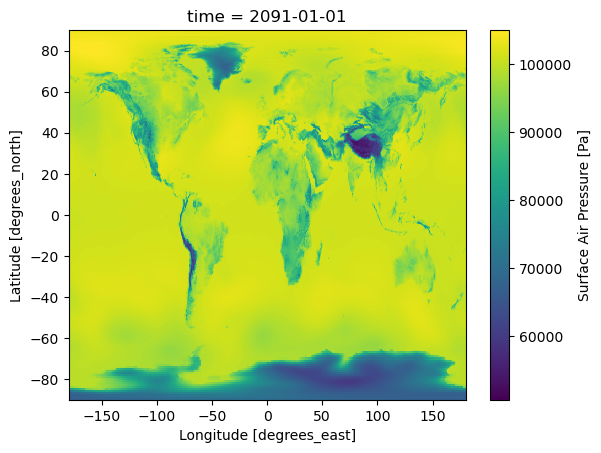

In [26]:
ps.isel(time=0).plot()

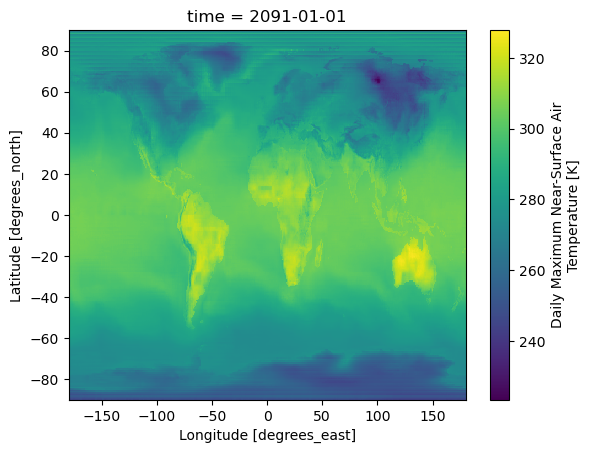

In [27]:
tasmax.isel(time=0).plot()

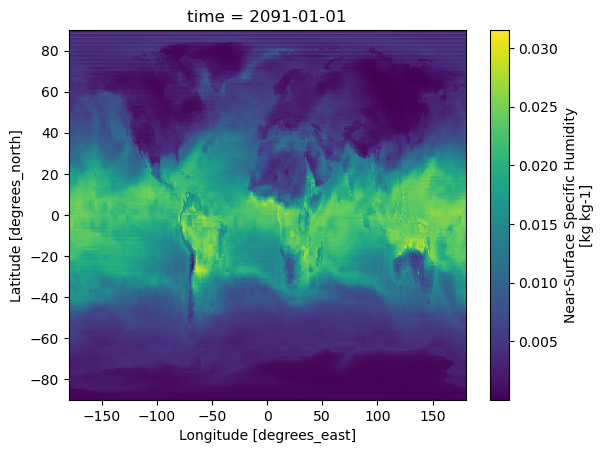

In [28]:
huss.isel(time=0).plot()

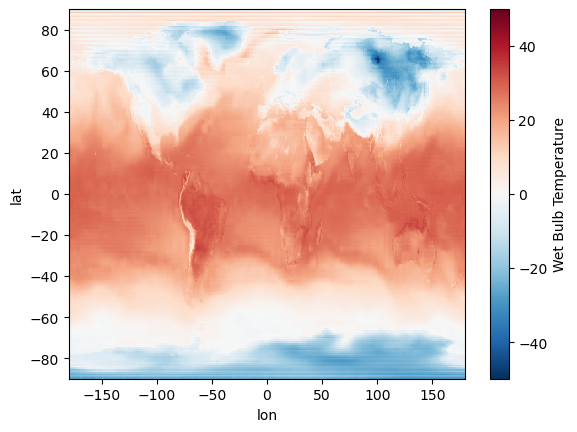

In [29]:
(Tw_da-273.15).plot()

# Try pseudo-adiabatic

In [30]:
time = 200
ps_arr = ps.isel(time=time).values.astype(float)
tasmax_arr = tasmax.isel(time=time).values.astype(float)
huss_arr = huss.isel(time=time).values.astype(float)


Tw = thermo.wet_bulb_temperature(ps_arr, tasmax_arr, huss_arr, saturation ='pseudo')


In [31]:
Tw = thermo.wet_bulb_temperature(ps.isel(time=time).values.astype(float),  tasmax.isel(time=time).values.astype(float), huss.isel(time=time).values.astype(float), saturation ='pseudo')


In [32]:
Tw_da = xr.DataArray(Tw, coords=[ ('lat', tasmax.lat.values), ('lon',tasmax.lon.values)], name="Wet Bulb Temperature")
Tw_da

<xarray.DataArray 'Wet Bulb Temperature' (lat: 360, lon: 720)>
array([[274.43464952, 274.44737754, 274.39039022, ..., 274.39609955,
        274.36729998, 274.36176706],
       [275.62713877, 275.61898564, 275.62232482, ..., 275.61916751,
        275.59644632, 275.61517317],
       [277.42626156, 277.44747015, 277.47382774, ..., 277.461089  ,
        277.50559387, 277.49775541],
       ...,
       [216.07853486, 216.24355294, 216.14599317, ..., 216.21490238,
        216.61151814, 216.97614493],
       [213.85003432, 213.74234401, 214.45064301, ..., 213.75041911,
        214.33412283, 214.04698739],
       [212.98382227, 212.81293542, 213.57198655, ..., 212.98794455,
        213.75025384, 213.72413031]])
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8

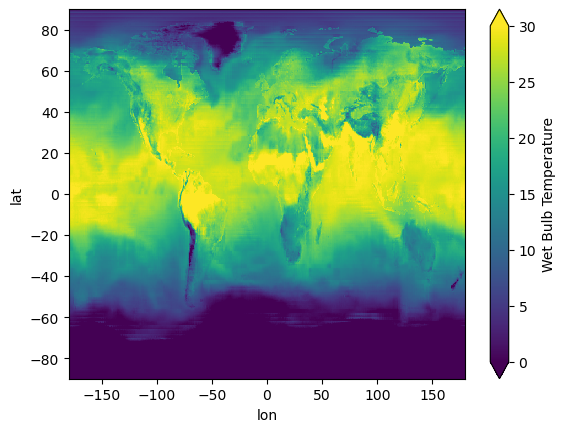

In [33]:
(Tw_da-273.15).plot(vmin=0,vmax=30)

## Parallelize with Dask

In [34]:
ps_dask = ps.isel(time=slice(0,100)).chunk({"time": 10,"lat": 50, "lon": 50 }).astype(float)
tasmax_dask = tasmax.isel(time=slice(0,100)).chunk({"time": 10,"lat": 50, "lon": 50 }).astype(float)
huss_dask = huss.isel(time=slice(0,100)).chunk({"time": 10,"lat": 50, "lon": 50 }).astype(float)

In [35]:
import dask.array as da

def calc_wet_bulb(ps_chunk, tasmax_chunk, huss_chunk):
    return thermo.wet_bulb_temperature(ps_chunk, tasmax_chunk, huss_chunk, saturation='pseudo')


### Hide

In [36]:

# Apply the function using map_blocks
wet_bulb_result = da.map_blocks(calc_wet_bulb, ps_dask, tasmax_dask, huss_dask, dtype=float)

HDF5-DIAG: Error detected in HDF5 (1.14.0) MPI-process 0:
  #000: H5A.c line 679 in H5Aopen_by_name(): unable to synchronously open attribute
    major: Attribute
    minor: Can't open object
  #001: H5A.c line 641 in H5A__open_by_name_api_common(): unable to open attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Can't open object
  #002: H5A.c line 464 in H5A__open_common(): unable to open attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Can't open object
  #003: H5VLcallback.c line 1138 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #004: H5VLcallback.c line 1105 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #005: H5VLnative_attr.c line 161 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #006: H5Aint.c line 658 in H5A__open_by_name(): un

In [37]:
wet_bulb_temperature_result = wet_bulb_result.compute()


HDF5-DIAG: Error detected in HDF5 (1.14.0) MPI-process 0:
  #000: H5A.c line 679 in H5Aopen_by_name(): unable to synchronously open attribute
    major: Attribute
    minor: Can't open object
  #001: H5A.c line 641 in H5A__open_by_name_api_common(): unable to open attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Can't open object
  #002: H5A.c line 464 in H5A__open_common(): unable to open attribute: '_QuantizeBitGroomNumberOfSignificantDigits'
    major: Attribute
    minor: Can't open object
  #003: H5VLcallback.c line 1138 in H5VL_attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #004: H5VLcallback.c line 1105 in H5VL__attr_open(): attribute open failed
    major: Virtual Object Layer
    minor: Can't open object
  #005: H5VLnative_attr.c line 161 in H5VL__native_attr_open(): can't open attribute
    major: Attribute
    minor: Can't open object
  #006: H5Aint.c line 658 in H5A__open_by_name(): un

### continue

In [38]:
wet_bulb_temperature_result.shape

(100, 360, 720)

In [39]:
Tw_da = xr.DataArray(wet_bulb_temperature_result, coords=[ ('time', tasmax.isel(time=slice(0,100)).time.values), ('lat', tasmax.lat.values), ('lon',tasmax.lon.values)], name="Wet Bulb Temperature")

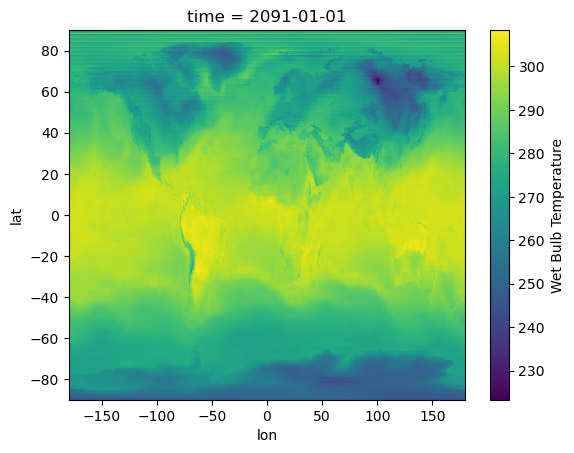

In [40]:
Tw_da.isel(time=0).plot()

In [45]:
Tw_da

<xarray.DataArray 'Wet Bulb Temperature' (time: 10, lat: 360, lon: 720)>
array([[[258.48148231, 258.25174653, 257.9886049 , ..., 258.03437403,
         258.85228482, 258.67508924],
        [265.75684805, 265.93265339, 265.7288587 , ..., 265.90196092,
         265.76489022, 265.70356087],
        [278.65200978, 278.57309649, 276.39008224, ..., 277.41046607,
         276.43977491, 276.52819259],
        ...,
        [248.86150809, 248.94209025, 248.96900517, ..., 248.82100941,
         248.85027897, 249.07106341],
        [246.13525843, 246.07268635, 246.03217216, ..., 246.07064334,
         246.09471858, 246.00564577],
        [244.43038167, 244.43846643, 244.17109229, ..., 244.54715086,
         244.28038717, 244.25644073]],

       [[256.17425792, 256.10851488, 256.57346353, ..., 256.88501092,
         256.65099503, 256.58748381],
        [264.60005359, 264.64888538, 264.56101036, ..., 264.62762441,
         264.67869168, 264.55315876],
        [278.31008773, 278.35120229, 278.69906237, ..., 278.01789461,
         277.89738046, 277.89742257],
...
        [249.29193321, 249.3456272 , 249.15665265, ..., 249.09607828,
         249.27074708, 249.32564856],
        [246.69992438, 246.63338343, 246.74577998, ..., 246.35435512,
         246.41478139, 246.44859169],
        [245.3660226 , 245.34087275, 245.40968142, ..., 244.70564466,
         244.68429429, 244.65611428]],

       [[258.04692472, 258.1328236 , 257.82450693, ..., 258.05154163,
         258.5506564 , 258.45154119],
        [265.96074084, 265.87410844, 265.72272636, ..., 266.10013037,
         266.07504309, 266.02789464],
        [278.89658579, 278.80063483, 276.90010755, ..., 277.45572832,
         277.05676325, 277.03888643],
        ...,
        [249.10311568, 249.04510155, 248.99826937, ..., 249.3421643 ,
         249.12272891, 249.03432761],
        [246.10075318, 246.10410926, 246.16250907, ..., 246.42918872,
         246.50435195, 246.40758064],
        [243.96691098, 243.9652791 , 244.50766322, ..., 244.52531695,
         244.66337642, 244.74888976]]])
Coordinates:
  * time     (time) datetime64[ns] 2091-01-01 2091-01-02 ... 2091-01-10
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Attributes:
    units:    K

## Testing function

In [41]:
def calc_wbgt_newt(GCM, 
                scenario1, 
                scenario2=None,  
                #chunk_version=2, 
                variables=None,
                save=True,
                overwrite=False,
                outdirname=None): 

    def calc_wet_bulb(ps_chunk, tasmax_chunk, huss_chunk):
        return thermo.wet_bulb_temperature(ps_chunk, tasmax_chunk, huss_chunk, saturation='pseudo')

    # input directory and input files
    dir1, dir2 = get_dirpaths(GCM, scenario1, scenario2); # utils
    print('input dir:', dir1)
    filepaths = [get_filepaths(VAR,dir1,dir2) for VAR in variables]  # utils

    if scenario2 is None:
        experiment=scenario1
    else:
        experiment=scenario1+'-'+scenario2 # TEST: delete this option and run only one scenario at a time? to make separate folders

    # make output directory in scratch  
    scratchdir =  make_outdir(GCM, 
                              makedirs=True, 
                              scratchdir=True,
                              outdirname=outdirname,
                             experiment=experiment) # utils

    for i in range(len(filepaths[0])):
        print(i)

        # check if output file already exists
        if overwrite==False and save==True:

            startyear,endyear = xr.open_dataarray(filepaths[0][i]).time.dt.year[[0,-1]]
            filesavename = get_filesavename(GCM, 
                                            scenario1,
                                            scenario2, 
                                            ext='WBGT', 
                                            startyear=startyear.values, 
                                            endyear=endyear.values, 
                                            keep_scenario=True,
                                           variable='tasmax') # get basename from input file, not from output WBGT file  

            if os.path.exists(os.path.join(scratchdir,filesavename)):
                print(f'wbgt {i} exists')
                exists=True
            else:
                exists=False 

    # TEST: to indent for real version!
    if overwrite==True or exists==False:
        print(f'calculating tw and wbgt {i}')

        # open variables 
        # TEST: remove this isel time slice for real version!
        tasmax,huss,ps= [xr.open_dataarray(files[i], engine="h5netcdf").isel(time=slice(0,10)).chunk({"time": 30,"lat": lat_chunk, "lon": lon_chunk }).astype(float) for files in filepaths]

        # check units
        if not (tasmax.attrs['units'] == 'K' and 
                huss.attrs['units'] == 'kg kg-1' and 
                ps.attrs['units'] == 'Pa'):
            raise ValueError("Units are incorrect")
        
        # calculate wet bulb temperature (K) 
        Tw = da.map_blocks(calc_wet_bulb, ps, tasmax, huss, dtype=float)
        Tw_compute = Tw.compute()
        Tw_da = xr.DataArray(Tw_compute, coords=[ ('time', tasmax.time.values), ('lat', tasmax.lat.values), ('lon',tasmax.lon.values)], name="Wet Bulb Temperature") 

        # calculate wet bulb globe temperature (deg C) 
        WBGT = (0.7*Tw_da + 0.3*tasmax).compute() - 273.15
        
        if save==True:
            filesavename = get_filesavename(GCM, scenario1,scenario2, ext='Tw', data=Tw_da,variable='tasmax',keep_scenario=True)
            Tw_da.attrs['units'] = 'K'
            Tw_da.rename('Tw').to_netcdf(os.path.join(scratchdir, filesavename))
            print(f'Tw {i} calculated and saved')
        
            filesavename = get_filesavename(GCM, scenario1,scenario2, ext='WBGT', data=WBGT,variable='tasmax', keep_scenario=True)
            WBGT.attrs['units'] = 'C'
            WBGT.rename('WBGT').to_netcdf(os.path.join(scratchdir, filesavename))
            print(f'wbgt {i} calculated and saved')


    return Tw_da, WBGT

In [42]:
flags['metric'] = 'WBGT'

Tw_da, WBGT = calc_wbgt_newt(GCM, 
                'ssp370', 
                scenario2=None,  
               # chunk_version=2, 
                variables=VARs,
                save=True,
                overwrite=False,
                outdirname='output_jan25')

input dir: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/ssp370/CanESM5
outdir exists: /scratch/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_jan25/WBGT/ISIMIP3b/ssp370/CanESM5
0
1
2
3
4
5
6
7
8
calculating tw and wbgt 8
Tw 8 calculated and saved
wbgt 8 calculated and saved


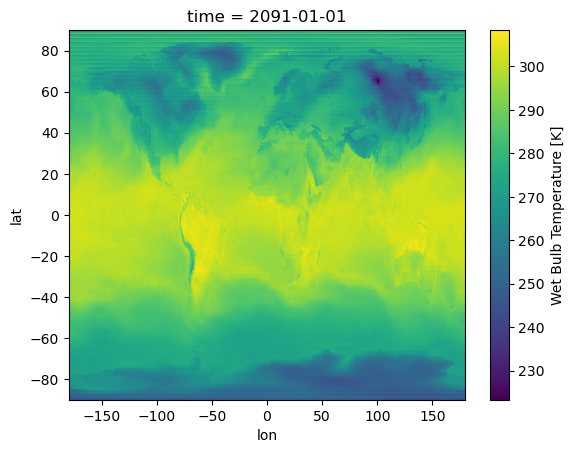

In [43]:
Tw_da.isel(time=0).plot()

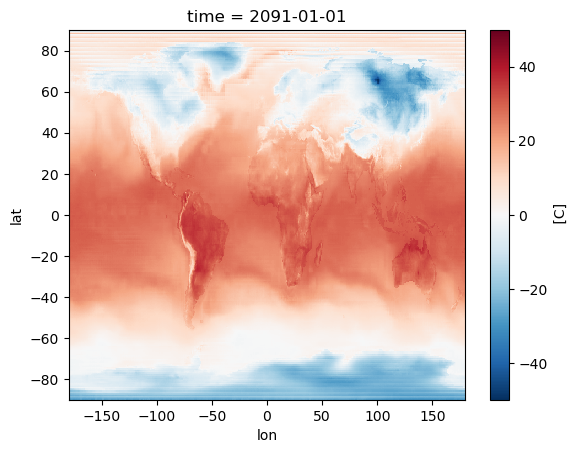

In [44]:
WBGT.isel(time=0).plot()

In [47]:
WBGT.rename('wbgt')

<xarray.DataArray 'wbgt' (time: 10, lat: 360, lon: 720)>
array([[[-14.36777806, -14.60258603, -14.8728722 , ..., -14.82242255,
         -13.97486974, -14.16086038],
        [ -7.00041266,  -6.82221587,  -7.02729281, ...,  -6.8525629 ,
          -6.9972276 ,  -7.06251532],
        [  6.04337889,   5.96538873,   3.743602  , ...,   4.78335896,
           3.79155215,   3.88017793],
        ...,
        [-24.00943824, -23.92576174, -23.90069113, ..., -24.05992476,
         -24.02883427, -23.7991936 ],
        [-26.79009082, -26.85154723, -26.89423059, ..., -26.85444676,
         -26.83226114, -26.92328642],
        [-28.51970603, -28.51216072, -28.7834962 , ..., -28.39526741,
         -28.67344029, -28.69823197]],

       [[-16.69065679, -16.76048062, -16.28594125, ..., -15.97811809,
         -16.22406117, -16.28752537],
        [ -8.15831637,  -8.11074911,  -8.19996548, ...,  -8.13758858,
          -8.07802861,  -8.20535173],
        [  5.72397975,   5.76564141,   6.1193638 , ...,   5.41705198,
           5.2959245 ,   5.29824279],
...
        [-23.57042245, -23.51391728, -23.70706831, ..., -23.77483505,
         -23.59354284, -23.5363618 ],
        [-26.19715773, -26.26539777, -26.1521041 , ..., -26.55885297,
         -26.49872468, -26.46212565],
        [-27.54001526, -27.56617575, -27.50075658, ..., -28.23130814,
         -28.25198917, -28.28164866]],

       [[-14.84247618, -14.75706926, -15.0674649 , ..., -14.84094723,
         -14.33620189, -14.43703091],
        [ -6.83502841,  -6.92278901,  -7.08096899, ...,  -6.69920501,
          -6.72909826,  -6.77635693],
        [  6.27600483,   6.19136174,   4.21432821, ...,   4.80350689,
           4.3731968 ,   4.35692021],
        ...,
        [-23.75025707, -23.81012508, -23.86258687, ..., -23.50342323,
         -23.73156107, -23.82322867],
        [-26.80789532, -26.80220897, -26.74314673, ..., -26.47129946,
         -26.3943688 , -26.49399195],
        [-28.97433266, -28.97683911, -28.42005231, ..., -28.40868805,
         -28.26612814, -28.17860157]]])
Coordinates:
  * time     (time) datetime64[ns] 2091-01-01 2091-01-02 ... 2091-01-10
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Attributes:
    units:    C